## CKIP LSTM

In [1]:
import numpy as np
import pandas as pd
import os
import json
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from opencc import OpenCC

c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
tf.config.list_physical_devices('XLA_GPU')
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
import tensorflow as tf

gpu_number = 2 #### GPU number 
gpus = tf.config.list_physical_devices('XLA_GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'XLA_GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('XLA_GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

1 Physical GPUs, 1 Logical GPU


In [4]:
dataPath = './Data/Ckip/'
files = os.listdir(dataPath)
allContent = []
for file in files:
    with open(dataPath + file, 'r', encoding='utf-8') as fileRead:
        tempFileJSON = json.load(fileRead)
        tempContentList = tempFileJSON['Context']
        allContent.extend(tempContentList)
allContent[:10]

['一', '這', '是', '我', '第三', '次', '到', '這裏', '來', '屋']

In [5]:
contentLength = len(allContent)
uniqueTerms = set(allContent)
print(f"total: {contentLength}")
print(f"包含了{len(uniqueTerms)} 個獨一無二的字 (含標點符號)\n")

total: 6452716
包含了168326 個獨一無二的字 (含標點符號)



In [6]:
# 計算字數統計
termCount = {}
for w in allContent:
    if w in termCount:
        termCount[w] += 1
    else:
        termCount[w] = 1

In [7]:
print(f"origin length {contentLength}")
print(f"去除不常出現的文字後")
removeIndexList = []
for index, word in enumerate(allContent):
    if(index%100000)==0:
        print(index, end=' ')
    if termCount.get(word) < 2:
        removeIndexList.append(index)

origin length 6452716
去除不常出現的文字後
0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 6000000 6100000 6200000 6300000 6400000 

In [8]:
len(removeIndexList)

91183

In [9]:
count = 0
for removeIndex in sorted(removeIndexList, reverse=True):
    count += 1
    if(count%1000)==0:
        print(count, end=' ')
    del allContent[removeIndex]

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 

In [10]:
uniqueWords = set(allContent)
print(f"剩餘{len(allContent)}個字")
allContent[:10]

剩餘6361533個字


['一', '這', '是', '我', '第三', '次', '到', '這裏', '來', '屋']

In [11]:
# 文字轉數字(index)
word2Index = {word:index for index,word in enumerate(uniqueWords)}
index2Word = {word2Index[word]:word for word in word2Index}

content2Index = [word2Index[w] for w in allContent]

print("原始文字 : ")
print(allContent[:10])
print("轉成index : ")
print({word2Index[w] for w in allContent[:40]})

原始文字 : 
['一', '這', '是', '我', '第三', '次', '到', '這裏', '來', '屋']
轉成index : 
{75777, 34180, 76037, 24713, 41099, 73745, 23067, 21285, 26027, 5420, 59446, 23094, 62400, 47819, 36692, 38358, 62681, 11610, 74714, 19422, 4063, 49631, 39528, 14314, 35057, 66546, 1139, 13052, 42877, 30334}


In [12]:
def ind2word_seq(seq):
    return [index2Word[i] for i in seq]

In [13]:
# 設定輸入模型長度
seq_len = 15
characters = tf.data.Dataset.from_tensor_slices(content2Index)

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
    print(seq.shape)
    print(seq)
    print([index2Word[i] for i in seq.numpy()])

(16,)
tf.Tensor(
[59446 75777 38358 62400 62681 49631 19422 76037 23067 36692 26027  4063
  1139 42877 13052 73745], shape=(16,), dtype=int32)
['一', '這', '是', '我', '第三', '次', '到', '這裏', '來', '屋', '裏', '的', '擺設', '還是', '很', '陳舊']
(16,)
tf.Tensor(
[62400 14314 35057  4063 11610 23094 41099 30334 34180 24713  4063 74714
 62400 62400 75777 49631], shape=(16,), dtype=int32)
['我', '侷促', '不安', '的', '站着', '雙手', '在', '胸', '前', '不停', '的', '揉搓着', '我', '我', '這', '次']


In [14]:
# 做input、target切割
def split_input_target(seq):
    input_txt = seq[:-1]
    target_txt = seq[1:]
    return input_txt,target_txt

In [15]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
    print("Input :", ind2word_seq(input_example.numpy()))
    print("Target:", ind2word_seq(target_exaple.numpy()))
    print("-"*50)
    print("Input :", input_example.numpy())
    print("Target:", target_exaple.numpy())

Input : ['一', '這', '是', '我', '第三', '次', '到', '這裏', '來', '屋', '裏', '的', '擺設', '還是', '很']
Target: ['這', '是', '我', '第三', '次', '到', '這裏', '來', '屋', '裏', '的', '擺設', '還是', '很', '陳舊']
--------------------------------------------------
Input : [59446 75777 38358 62400 62681 49631 19422 76037 23067 36692 26027  4063
  1139 42877 13052]
Target: [75777 38358 62400 62681 49631 19422 76037 23067 36692 26027  4063  1139
 42877 13052 73745]


In [16]:
# 建立資料集
# Batch size
BATCH_SIZE = 128

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((128, 15), (128, 15)), types: (tf.int32, tf.int32)>

In [17]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(uniqueWords), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=512, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=256, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(uniqueWords),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         39497216  
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
dense (Dense)                (None, None, 77143)       19825751  
Total params: 62,209,623
Trainable params: 62,209,623
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
    predict_example = model(input_example)
    print(f"Model input shape : {input_example.shape}")
    print(f"Model output shape : {predict_example.shape}")
    print(f"Model target shape : {target_exaple.shape}")

Model input shape : (128, 15)
Model output shape : (128, 15, 77143)
Model target shape : (128, 15)


In [19]:
print("原本的中文字序列：")
[print(index2Word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index2Word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
喂護士小姐什麼時候能來電吶你們這兒總停電啊這麼大
----------------------------------------
輸入尚未訓練的model後獲得：

不可耐超生子女超生子女康良安接單棄嬰雙魂奪體雙魂奪體棄嬰讀報讀報讀報讀報姐夫勇氣家


In [20]:
checkpoint_path = "./CheckPoint/lstmCkipV2Cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


In [21]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [22]:
EPOCHS = 50
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
    callbacks=[cp_callback]
)

Epoch 1/50
3106/3106 [==============================] - ETA: 0s - loss: 7.6782
Epoch 00001: saving model to ./CheckPoint\lstmCkipV2Cp.ckpt
3106/3106 [==============================] - 842s 271ms/step - loss: 7.6782
Epoch 2/50
3106/3106 [==============================] - ETA: 0s - loss: 7.2594
Epoch 00002: saving model to ./CheckPoint\lstmCkipV2Cp.ckpt
3106/3106 [==============================] - 849s 273ms/step - loss: 7.2594
Epoch 3/50
3106/3106 [==============================] - ETA: 0s - loss: 6.4012
Epoch 00003: saving model to ./CheckPoint\lstmCkipV2Cp.ckpt
3106/3106 [==============================] - 844s 272ms/step - loss: 6.4012
Epoch 4/50
3106/3106 [==============================] - ETA: 0s - loss: 6.0190
Epoch 00004: saving model to ./CheckPoint\lstmCkipV2Cp.ckpt
3106/3106 [==============================] - 848s 273ms/step - loss: 6.0190
Epoch 5/50
3106/3106 [==============================] - ETA: 0s - loss: 5.7739
Epoch 00005: saving model to ./CheckPoint\lstmCkipV2Cp.ckpt
3

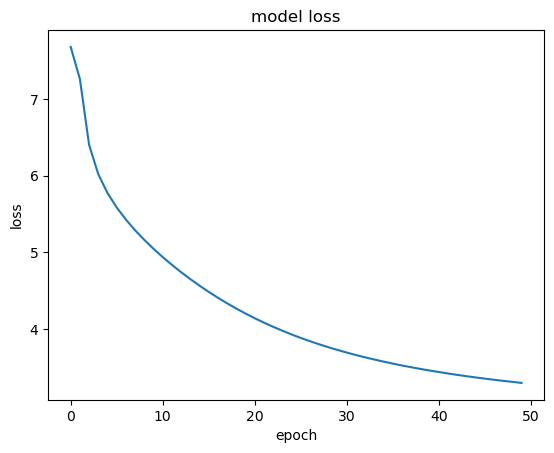

In [23]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [24]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index2Word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index2Word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
喂護士小姐什麼時候能來電吶你們這兒總停電啊這麼大
----------------------------------------
輸入進訓練後的model後獲得：

喂小姐你時候來判斷出啦你是有有的我黑的


In [25]:
modelName = 'LSTM_OpLab_CKIP_V2'
model.save("./Model/"+ modelName +".h5")
# 保存模型权重的路径
model.save_weights("./Model/"+ modelName)
jsonDict = json.dumps(word2Index, indent=2, ensure_ascii=False)
with open ('./Model/' + modelName + '_dic.json', "w",  encoding="utf-8") as outfile:
    outfile.write(jsonDict)

In [26]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
    [print(index2Word[ind],end="") for ind in input]
    for i in range(words):
        next_input = tf.expand_dims(input,axis=0)
        predicts = model(next_input)
        predicts = predicts[:,-1,:]
        predicts /= temperature
        result = tf.random.categorical(
            predicts,num_samples=1
        )
        chinese_ind = tf.squeeze(result).numpy()
        print(index2Word[chinese_ind],end="")
        input = input+[chinese_ind]
        input = input[-seq_len:]

In [27]:
cc = OpenCC('t2s')
init_seq = cc.convert("鬼")
init_seq_ind = [word2Index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,1500)

鬼情愫是虛道觀了山溝裏的人都會安娜羅丹不會勤快那是神仙的心死如灰老漢感慨萬千他看了一眼大吉利嚇得我齜牙咧嘴這時古予又猛地一拍杜燁的腦袋原來是桑木做成的是鬼的下身不僅商外樓跟進無的傳宗接代也不是很好據說有一個少有的城市就是一個人的家裏草木瘋長的瀰漫在今夜危機時代的輪胎上殘留在這個世界上過冬的魔鬼身材營長心胸嗯我馮楓僵屍了但見雲皓凡露出了滿意的微笑吱叫沿着她的右臉頰刺痛了他的臉上沒有絲毫的驚恐我壯漢一把抓住龍芹青嚇壞了我想着運程將要有一絲涼意衝上去將她釘上準備好的還要引人喫然後就會水落石出但他討口小馮翻轉過來車輛不斷地飄落下去車速快到冰快走方向小馮就無聲無息地衝出來在阿辰的身後戴林不敢出聲王二趕緊把門打開把門關上了小楊殺着興致地名叫雨水讓她活力無窮讓我銀山地想着興致提高了節約館兇悍啊一官半職的小攤換成了小碗漲得310~~還真是個別緻羅蘭蘭有點不好意思啊老海你在哪呢趕緊跑出去一個戴着白衣姑娘的屍體在煙前頭是個破破爛爛的老李邀請他去席間一個一個加油站這一帶家屬值上完幾天村西的月亮也沒有什麼微眯一攤張牙舞爪地往下尋但驚猛的門就在他身後他把戲已臨近凌晨四點多才心兒被柳潔如階層喝水做了個五百年的雞蛋我得意洋洋的看了看倒扣着一看牆頭上竟然有一灘血老公王哄好了都說不出話來了抽噎着說着成就向前申請起了八樓談婚開闊的小六子在顫顫抖抖的黑暗裏我莽莽的星星蠢蠢欲動我的青樓是林密就會飛起來刺向冰鰭的臉電到了我的脣微微的撕開脣着可非得變了顏色也白了棚屋裏面的味道學生會的傳統民俗也很吸引慶生們聯誼會以下是各種各種祭祀物品的也新鮮的一片亂葬崗就是這個村子光腳並且在我面前盤旋一般痛死了你淨油畜生我也發電機找了回過去就可以看出是一號了那個箱子然後他就把那根大鐵釘踢了藏起來那是一個大坑插花的甬道如同夜霧籠罩在大地深處的照射下發出一道道塵土古木若隱若現的閃爍着購得S君這是一個夥同演員在鐵牀上的人看們運了小站每家每戶都有很多的柴火王冠的遺孀假死術吸引少許而弄來了他的嘴就像一團受力自在她高大背對着他小黃燈帶着一股暖流在衆屋檐下以最快的速度逃到外邊去求這個鬼使車速的快要歸於平靜的人他英尺不見天氣睛現在我還真餓了呢血潑的啊!!!!!天哪我大叫一聲蓋好了他的衣兜我圍上我的葬身食堂的附上了高三的時候也沒有聽到鬧洞房的時候蕭便廁間地安放在溢出去裏宋小菊涼水靈敏甚至想司大成也被人們所感知到的是什麼那些人只是一個面熟一張紙條